# Processing Sequences
Thus far in our course we have done both classification and regression analyses.   For our classification, the data has been one of two types:
1.  Static feature data: for example, the pulsar dataset.   We have 8 individual features characterizing pulsars as well as background, and our challenge was to develop a model capable of classifying new instances based on those features.  We used fully connected networks (FCNs) to perform this task.  Other tools would work well here, such as SVMs, decision trees, or random forests.
2.  Image data: Here we have predominantly used the MNIST dataset.   Here our challenge was again to classify our data as one of multiple possible classes (0-9).   We used both FCNs as well as convolutional neural networks (CNNs). 

The primary difference in the FCN vs CNN approach is the following:
* For FCNs the features are fixed.   For example, when classifying the MNIST sample, we used the pixel intensity at each of the 784 specific pixel positions as our features.
* For CNNs the features are "discovered".   Again, when classifying the MNIST sample, depending on the exact number of convolutional and pooling layers, the values used in kernels or filters we specify in the convolutional layers are determined (fit) by our training sample, and could be features over small sections of pixels or even over the whole image.

In this workbook we will deal with a different sort of dataset: ordered sequences.   We will focus initially on classification of time sequences, but will extend this to classification of text sequences.

This workbook is based on examples and code from these sources:
1.  [Human Activity Recognition (HAR) Tutorial with Keras and Core ML (Part 1)](https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0)  by Nils Ackermann
2.  [Introduction to 1D Convolutional Neural Networks in Keras for Time Sequences](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf) by Nils Ackermann
3.  [How to Develop 1D Convolutional Neural Network Models for Human Activity Recognition](https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/) by Jason Brownlee

# HAR: Human Activity Recognition
The analysis we will do in this workbook deals with data collected from smartphones carried by human subjects engaged in normal daily activities: walking, sitting, jogging, standing, climbing upstairs, or descending downstairs.   The smartphones were carried in the front pants pocket by 36 subjects.   The raw data collected are the accelerometer readings in the x,y, and z directions (relative to the smartphones) collected at 50 Hz (or 50 steps/second).   

Given the phone orientation when a person is standing:
* the **x-direction** is side to side
* the **y-direction** is up and down
* the **z-direction** is forward and backward
as shown in this figure:
![har_fig](har_fig.png)

A paper describing the results can be found [here](http://www.cis.fordham.edu/wisdm/includes/files/sensorKDD-2010.pdf).

A video of the activity can be found [here](https://www.youtube.com/watch?v=XOEN9W05_4A).

# Get the data:  

The data can be found here:  http://www.cis.fordham.edu/wisdm/dataset.php

I have placed this in the scratch area on OSC at this location:
/fs/scratch/PAS1495/physics6820/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

There is a text file in the same location that has more descriptive information about the data.

The columns in the above files are the following:
* user-id: this is a number from 1-30
* activity: this is a label from the following: Jogging, Walking, Standing, Sitting, Upstairs, Downstairs
* timestamp: this is a relative timestamp from phone's uptime in nanoseconds (so the text file says - it is not obvious that this is correct from my inspection of the data)
* x-axis: a floating-point values between -20 .. 20
                The acceleration in the x direction as measured
                by the android phone's accelerometer. 
                A value of 10 = 1g = 9.81 m/s^2, and
                0 = no acceleration.
                The acceleration recorded includes gravitational
                acceleration toward the center of the Earth, so
                that when the phone is at rest on a flat surface
                the vertical axis will register +-10. 
* y-axis: see x-axis
* z-axis: see x-axis

Let's read the data in so we can explore it.

In [1]:
import pandas as pd
import numpy as np
#
# Use this to convert text to floating point
def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
df = pd.read_csv('/fs/scratch/PAS1495/physics6820/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt',
                     header=None,
                     names=column_names)

# Last column has a ";" character which must be removed ...
df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
#
# Get rid if rows wth missing data
df.dropna(axis=0, how='any', inplace=True)
print(df.head(20))


    user-id activity       timestamp    x-axis     y-axis     z-axis
0        33  Jogging  49105962326000 -0.694638  12.680544   0.503953
1        33  Jogging  49106062271000  5.012288  11.264028   0.953424
2        33  Jogging  49106112167000  4.903325  10.882658  -0.081722
3        33  Jogging  49106222305000 -0.612916  18.496431   3.023717
4        33  Jogging  49106332290000 -1.184970  12.108489   7.205164
5        33  Jogging  49106442306000  1.375655  -2.492524  -6.510526
6        33  Jogging  49106542312000 -0.612916  10.569390   5.706926
7        33  Jogging  49106652389000 -0.503953  13.947236   7.055340
8        33  Jogging  49106762313000 -8.430995  11.413852   5.134871
9        33  Jogging  49106872299000  0.953424   1.375655   1.648062
10       33  Jogging  49106982315000 -8.199450  19.572440   2.724070
11       33  Jogging  49107092330000  1.416516   5.788648   2.982856
12       33  Jogging  49107202316000 -1.879608  -2.982856  -0.299648
13       33  Jogging  491073123320

In [3]:
print(df[df['user-id']==33].shape)

(29453, 6)


# Simple plots
Lets make some simple plots which show how many samples are in the data for: 
* each activity
* each user

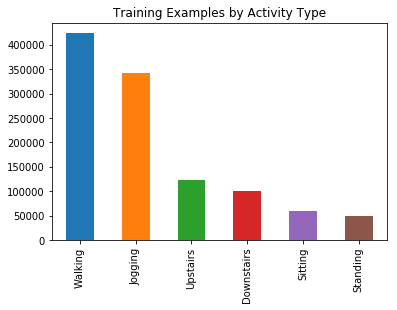

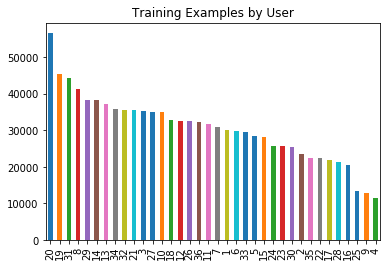

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline

# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
#print(df['user-id'].value_counts())
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

# Splitting the data
We need to split the data into test and train data.   The way we will do this is to see how much time each user spends in each activity.   We will use defaultdicts to keep track of this.

Also, since each "step" in time is 1/50.0 of a second, we divide by 50 to convert steps to seconds (so activityStepsByUser is actual activity by user in seconds).

Be patient!   This next code block takes a minute or so.

In [3]:
from collections import defaultdict
from functools import partial

activitySteps = defaultdict(list)
activityStepsByUser = defaultdict(partial(defaultdict, float))
activitiesByUser = defaultdict(int)

oldActivity = ''
oldUser = -1
startTime = -1
num = 0
steps = 0
activities = set()
#
# Loop over each row in our dataset
for index, row in df.iterrows():
#
# Data from the current row
    activity = row['activity']
    activities.add(activity)
    user = row['user-id']
    currentTime = row['timestamp']
    steps += 1
'''We are simply counting how many steps there are for each user.''''
#
# Is the activty of this row different from our last row?  How about the user?
# If either of these change, collect data
    if activity != oldActivity or user != oldUser:
#
# If oldUser is less than zero then we have not started collecting data yet!
        if oldUser >= 0:
#
# Something changed, so store the old data, and reset the variables to the current activity/user
            activitySteps[oldActivity].append(steps/50.0) #This counts how many seconds of data there are for the six activities.
            activityStepsByUser[oldUser][oldActivity] += steps/50.0 #This counts how many seconds each person spends on each activity.
            activitiesByUser[oldUser] += 1 #How much time of data each user contributes.
            oldActivity = activity
            oldUser = user
            startTime = currentTime
            steps = 0
        else:
            oldUser = user
            startTime = currentTime
            steps = 0
    num += 1


## Printout
Now we can printout how much time each user spends in each activity.   We see that some of the participants don't spend any time in some of the activites.   we also note that if we order the particpants by user-id, that approximately every 4 users corresponds to about 10% of the data.   

Also note that the amount of time each user spends in each ativity is typically about 50-60s.

User    Num    Jog    Walk   Stand     Sit  Upstairs   DownSt  TotalTime  TimePerAct Frac
0 	 0 	0.0 	0.0 	0.0 	0.0 	0.0 	0.0 	0.0   0.0   0.0
1 	 12 	0.0 	59.0 	62.0 	221.0 	257.0 	0.0 	600.0   50.0   0.03
2 	 4 	0.0 	0.0 	0.0 	236.0 	235.0 	0.0 	470.0   118.0   0.05
3 	 14 	32.0 	67.0 	68.0 	220.0 	259.0 	56.0 	703.0   50.0   0.08
4 	 8 	25.0 	35.0 	28.0 	18.0 	122.0 	0.0 	227.0   28.0   0.09
5 	 10 	33.0 	66.0 	68.0 	128.0 	245.0 	30.0 	570.0   57.0   0.12
6 	 19 	34.0 	29.0 	33.0 	236.0 	248.0 	14.0 	594.0   31.0   0.14
7 	 14 	51.0 	45.0 	72.0 	184.0 	221.0 	47.0 	619.0   44.0   0.17
8 	 13 	54.0 	67.0 	89.0 	206.0 	342.0 	65.0 	824.0   63.0   0.21
9 	 2 	0.0 	0.0 	0.0 	0.0 	258.0 	0.0 	258.0   129.0   0.22
10 	 13 	0.0 	76.0 	86.0 	242.0 	261.0 	33.0 	698.0   54.0   0.25
11 	 8 	0.0 	53.0 	88.0 	249.0 	243.0 	0.0 	633.0   79.0   0.28
12 	 14 	46.0 	57.0 	53.0 	247.0 	216.0 	33.0 	653.0   47.0   0.31
13 	 12 	24.0 	85.0 	93.0 	247.0 	261.0 	33.0 	742.0   62.0   0.35
14 	 8 	0.0 	5

/apps/python/3.6-conda5.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


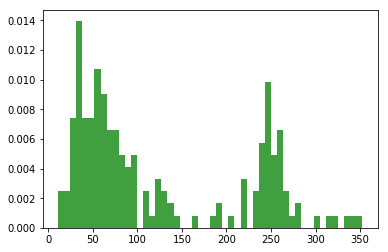

In [4]:
#
# How much time total for all users and all activities?
total_time = 0.0
for user in range(37):
    for activity in activities:
        total_time += activityStepsByUser[user][activity]

print('User    Num    Jog    Walk   Stand     Sit  Upstairs   DownSt  TotalTime  TimePerAct Frac')
summedFrac = 0.0
segmentTimes = []
for user in range(37):
    print(user,'\t',activitiesByUser[user],'\t',end='')
    total_user = 0.0
    for activity in activities:
        total_user += activityStepsByUser[user][activity]
        if activityStepsByUser[user][activity]> 0.0:
#        if activityStepsByUser[user][activity]> 0.0 and activityStepsByUser[user][activity] < 100:
            segmentTimes.append(activityStepsByUser[user][activity])
        print(round(activityStepsByUser[user][activity],0),'\t',end='')
    summedFrac += total_user/total_time
    timePerActivity = 0.0
    if activitiesByUser[user]>0:
        timePerActivity = total_user / float(activitiesByUser[user])
    print(round(total_user,0),' ',round(timePerActivity,0),' ',round(summedFrac,2))

plt.hist(segmentTimes, 50, normed=1, facecolor='green', alpha=0.75)
plt.show()

# Data Split

We might want to keep all of a given user's data in either the test or train sample - this way we use data from different people to predict behavior of new people.

If we want a 80%/20% split, it looks like we can define:
* training: user-id <=28
* testing: user-id>28

We also need to convert the 'activity' column tfrom text ('Jogging', etc) to a number (1-6) so we can one-hot encode it later.


In [6]:
from sklearn import preprocessing
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())
print(df[df['activity']!='Jogging'].head())

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

     user-id activity       timestamp    x-axis     y-axis    z-axis  \
597       33  Walking  49394992294000  0.844462   8.008764  2.792171   
598       33  Walking  49395102310000  1.116869   8.621680  3.786457   
599       33  Walking  49395202316000 -0.503953  16.657684  1.307553   
600       33  Walking  49395302292000  4.794363  10.760075 -1.184970   
601       33  Walking  49395412338000 -0.040861   9.234595 -0.694638   

     ActivityEncoded  
597                5  
598                5  
599                5  
600                5  
601                5  


## Normalizing feature data
As usual, we want to normalize our features.   We will use **training set maximums** to do this.

In [7]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
max_x = df_train['x-axis'].max()
max_y = df_train['y-axis'].max()
max_z = df_train['z-axis'].max()

print("max values ", max_x,max_y,max_z)

df_train['x-axis'] = df_train['x-axis'] / max_x
df_train['y-axis'] = df_train['y-axis'] / max_y
df_train['z-axis'] = df_train['z-axis'] / max_z
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})#Round the data to 4 decimal places.
print(df_train.head())

df_test['x-axis'] = df_test['x-axis'] / max_x
df_test['y-axis'] = df_test['y-axis'] / max_y
df_test['z-axis'] = df_test['z-axis'] / max_z
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

max values  19.95 20.04 19.61
      user-id activity       timestamp  x-axis  y-axis  z-axis  \
8489       17  Walking  57869902574000  0.0287  0.4894 -0.0271   
8490       17  Walking  57870012316000  0.0000  0.5084 -0.0292   
8491       17  Walking  57870122301000 -0.0116  0.4914 -0.0354   
8492       17  Walking  57870222246000  0.0075  0.5029 -0.0257   
8493       17  Walking  57870332292000  0.0075  0.5063 -0.0313   

      ActivityEncoded  
8489                5  
8490                5  
8491                5  
8492                5  
8493                5  


# Plotting 
Let's make some plots to see what the data looks like.   We will select out various activites from our primary dataframe **df**, and see if they make sense:

In [15]:
df_standing  = df_train[df_train['activity'] == 'Standing'].iloc[:200]
print(df_standing.head())
# gca stands for 'get current axis'
ax = plt.gca()

df_standing.plot(kind='line',x='timestamp',y='x-axis',ax=ax)
df_standing.plot(kind='line',x='timestamp',y='y-axis', color='red', ax=ax)
df_standing.plot(kind='line',x='timestamp',y='z-axis', color='green', ax=ax)

plt.show()


df_walking  = df_train[df_train['activity'] == 'Walking'][:200]
# gca stands for 'get current axis'
ax = plt.gca()

df_walking.plot(kind='line',x='timestamp',y='x-axis',ax=ax)
df_walking.plot(kind='line',x='timestamp',y='y-axis', color='red', ax=ax)
df_walking.plot(kind='line',x='timestamp',y='z-axis', color='green', ax=ax)

plt.show()

df_jogging  = df_train[df_train['activity'] == 'Jogging'][:200]
# gca stands for 'get current axis'
ax = plt.gca()

df_jogging.plot(kind='line',x='timestamp',y='x-axis',ax=ax)
df_jogging.plot(kind='line',x='timestamp',y='y-axis', color='red', ax=ax)
df_jogging.plot(kind='line',x='timestamp',y='z-axis', color='green', ax=ax)

plt.show()

df_upstairs  = df_train[df_train['activity'] == 'Upstairs'][:200]
# gca stands for 'get current axis'
ax = plt.gca()

df_upstairs.plot(kind='line',x='timestamp',y='x-axis',ax=ax)
df_upstairs.plot(kind='line',x='timestamp',y='y-axis', color='red', ax=ax)
df_upstairs.plot(kind='line',x='timestamp',y='z-axis', color='green', ax=ax)

plt.show()


        user-id  activity       timestamp  x-axis  y-axis  z-axis  \
223432       27  Standing  12535892255000 -0.0942  0.4915 -0.0118   
223433       27  Standing  12535942273000 -0.0095  0.4950 -0.0292   
223434       27  Standing  12535992231000 -0.0306  0.5125 -0.0451   
223435       27  Standing  12536042310000  0.0381  0.5274 -0.0896   
223436       27  Standing  12536092206000  0.0211  0.4726 -0.0570   

        ActivityEncoded  
223432                3  
223433                3  
223434                3  
223435                3  
223436                3  


NameError: name 'plt' is not defined

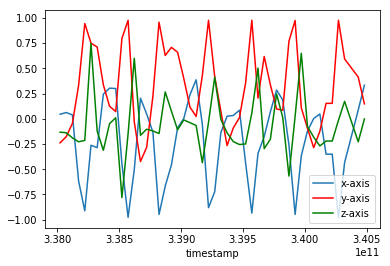

In [8]:

df_user  = df_train[df_train['user-id'] == 15][180:230]
# gca stands for 'get current axis'
ax = plt.gca()

df_user.plot(kind='line',x='timestamp',y='x-axis',ax=ax)
df_user.plot(kind='line',x='timestamp',y='y-axis', color='red', ax=ax)
df_user.plot(kind='line',x='timestamp',y='z-axis', color='green', ax=ax)

plt.show()

## Creating our labeled data samples
From our above plots and tables, we see that typical times that each user spends in a given activity is hundreds of seconds.   The smallest non-zero time is about 30 seconds, the largest amount of time is just under 900 seconds.

We will define our samples to be 1.6 seconds, and we will assign as the label of each sample the activity that occurs the most in that sample.  To help increase the total number of samples, we can also allow some overlap in our samples.   We will **not** allow any overlap in our test data however.

In [23]:
from scipy import stats

# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80    # since there are 50 measurements/sec, this is 1.6 seconds of data
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE_TRAIN = 40
STEP_DISTANCE_TEST = 80

def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0] #stats.mode finds the most common values that occurs in the array
        #The default axis is 0
        
        segments.append([xs, ys, zs]) #This segments is a list of lists (nx3). xs, ys, zs are the arrays.
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE_TRAIN,
                                              LABEL)
x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE_TEST,
                                              LABEL)
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'testing samples')
print('y_test shape: ', y_test.shape)
print(y_test[10])
#This segmentation doesn't distinguish users

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
x_test shape:  (3292, 80, 3)
3292 testing samples
y_test shape:  (3292,)
5


## Classifying Time Sequences Using a Fully Connected Network
Let's begin with something reasonably simple.   We have labeled samples, each 80 time steps long, with 3 channels of information at each time step.   Let's treat this as $80\times3=240$ total features.   We can easily write down a multi-layer network with a softmax output to classify this. 

Our network will look like the figure below:
![har_fcn_fig](sequence_fcn.png)
“Deep Neural Network Example” by Nils Ackermann is licensed under Creative Commons [CC BY-ND 4.0](https://creativecommons.org/licenses/by-nd/4.0/)

In [10]:

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

# Reshape the input data
input_shape = (num_time_periods*num_sensors)
#x_train = x_train.reshape(x_train.shape[0], input_shape)
#x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

# One-hot enocde the output labels
from keras.utils import np_utils
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
y_test_hot = np_utils.to_categorical(y_test, num_classes)
print('New y_test shape: ', y_test_hot.shape)

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 80, 3)
input_shape: 240


Using TensorFlow backend.


New y_train shape:  (20868, 6)
New y_test shape:  (3292, 6)


In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
model_m = Sequential()

model_m.add(Dense(100, activation='relu', input_shape=(80,3)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(6, activation='softmax'))
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


## Fit the FCN
Here we use the **callbacks** option to monitor the **validation loss**, waiting patience=4 epochs before deciding to stop training.   We also save the best model.

In [12]:
patience = 4
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.har_fcn.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
]

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(x_test, y_test_hot),
                      verbose=1)
best_val_acc =  history.history['val_acc'][-(patience+1)]
print("Best validation accuracy is:",best_val_acc)

Train on 20868 samples, validate on 3292 samples
Epoch 1/50
20868/20868 [==============================] - 10s 459us/step - loss: 0.9985 - acc: 0.6670 - val_loss: 0.8184 - val_acc: 0.6950
Epoch 2/50
20868/20868 [==============================] - 10s 456us/step - loss: 0.5724 - acc: 0.7979 - val_loss: 0.7704 - val_acc: 0.7181
Epoch 3/50
20868/20868 [==============================] - 9s 437us/step - loss: 0.5217 - acc: 0.8146 - val_loss: 0.8398 - val_acc: 0.7348
Epoch 4/50
20868/20868 [==============================] - 9s 435us/step - loss: 0.4994 - acc: 0.8208 - val_loss: 0.9455 - val_acc: 0.7123
Epoch 5/50
20868/20868 [==============================] - 10s 456us/step - loss: 0.4785 - acc: 0.8290 - val_loss: 0.9561 - val_acc: 0.7321
Epoch 6/50
20868/20868 [==============================] - 9s 441us/step - loss: 0.4633 - acc: 0.8328 - val_loss: 1.0226 - val_acc: 0.7324
Best validation accuracy is: 0.7181044904965531


# Convolutional Neural Networks for Sequences
The performance we obtained for a single train/test split was about 71% (evaluated where the validation losss was at a minimum).   Can we do better?

We recall that in our study of images, we found that 2D convolution could help - this was because there were features present in the data that were somewhat translationally and rotationally invariant.   The convolution process also allows us to **discover** features, rather than imposing the features from the outside.   We can also use the convolution process with sequences. In this case however, we will employ **1D convolution**.   

First lets define the network using Keras, then we will step through the layers to see if we can understand each of the steps.

In [13]:
from keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D
#
# Define a sequential model as usual
model_m = Sequential()
# 
# Our first layer gets the input from our samples - this is 80 time steps by 3 channels
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(80,3)))
#
# Anoth convolutional layer
model_m.add(Conv1D(100, 10, activation='relu'))
#
# Max pooling 
model_m.add(MaxPooling1D(3))
#
# Two more convolutional layers
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
#
# Global average pooling use this instead of "Flatten" - it helps reduce overfitting
model_m.add(GlobalAveragePooling1D())
#model_m.add(Flatten())

model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 160)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
__________

# Conv1D Details!
To understand how this works, refer to the figure below.   In most respects this sort of network is extremely similar to the 2D concolutinal networks we use for images, though there are some subtle differences.
1.  First, it is important to remember that our data is 80 steps in time, and there are 3 channels at each step.   The convolution moves across the **time dimension** (which is why it is 1d).
2.  In both of the figures on the left  underneath the first "Conv Layer" heading, time moves from top to bottom.
3.   The first convolutional layer has a **kernel** size of 10, and there are 100 such kernels (or filters).   Note that since our input data has 3 channels, our kernels **also** have 3 channels (so the kernels are really size 10x3). In our case, with a kernel size of 10, we convolve this across 10 time steps **and** 3 chanels at each time step, outputting one number, which can be thought of as the weighted average across the 3 channels and 10 time steps.  
4.  Since we have a default stride of 1, we move ahead 1 time step and do the same calculation.   Since we have 80 time steps, we end up with **71** total such calculations for each kernel.   Since we have 100 kernels (or filters), we have an output size for the first convolutional layer of $71x100$.
5.  The next convolutional layers proceed in the same way, and the max pooling layer behaves just like the corresponding from our image classification networks.
6.  Another tricky aspect of this network is a new layer called the GlobalAveragePooling1D.   This turns out to be very helpful to reduce overfitting.  The motivation for it can be found in this paper: [Network in Network](https://arxiv.org/pdf/1312.4400.pdf).


![har_fcn_fig](sequence_cnn.png).  

# Run the fitter!
We run the fitter in exactly the same way as we did the FCN above.

In [14]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.har_cnn.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(x_test, y_test_hot),
                      verbose=1)

Train on 20868 samples, validate on 3292 samples
Epoch 1/50
20868/20868 [==============================] - 38s 2ms/step - loss: 0.8246 - acc: 0.7083 - val_loss: 0.6801 - val_acc: 0.7415
Epoch 2/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.4410 - acc: 0.8446 - val_loss: 0.7403 - val_acc: 0.7351
Epoch 3/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.3559 - acc: 0.8699 - val_loss: 0.6492 - val_acc: 0.7570
Epoch 4/50
20868/20868 [==============================] - 36s 2ms/step - loss: 0.2905 - acc: 0.8986 - val_loss: 0.5440 - val_acc: 0.8360
Epoch 5/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.2285 - acc: 0.9233 - val_loss: 0.5909 - val_acc: 0.8360
Epoch 6/50
20868/20868 [==============================] - 38s 2ms/step - loss: 0.1990 - acc: 0.9334 - val_loss: 0.5938 - val_acc: 0.8509
Epoch 7/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.1658 - acc: 0.9451 - val_loss: 0.5862 - val_acc:

In [15]:
patience = 4
best_val_acc =  history.history['val_acc'][-(patience+1)]
print("Best validation accuracy is:",best_val_acc)

Best validation accuracy is: 0.8359659670479822


# Multi-headed Network
We see from above that the 1D convolutional neural network greatly outperforms the standard FCN.  Awesome!  But if you notice, a key parameter in the network is the kernel size.   We can see from our plots above comparing jogging/walking/sittig/climbing stairs, that the time structure of the various activities is different.  Meaning that a larger kernal size - that covers more time steps - might make more sense for some activities, while a smaller kernel size might be more appropriate for other activities.   Can we combine these in a single network?   Yes!   Enter the **multi-headed network**!

The basic idea is simple:
1.  We have 2 (or more) networks that get the same input.
2.  These two networks are then merged and produce the same softmax output as our above network.

To implement this network, it is necessary to use the Keras Functional API, which we have already introduced.  Before we do the multi-headed network, let's do a copy of the above CNN network using the functional API:

In [16]:
from keras.layers import Input,Conv1D, MaxPooling1D,GlobalAveragePooling1D
from keras.models import Model
# 
# Our first layer gets the input from our samples - this is 80 time steps by 3 channels
#model_m.add(Conv1D(100, 10, activation='relu', input_shape=(80,3)))
inputs1 = Input(shape=(80,3))
conv1 = Conv1D(100, 10, activation='relu')(inputs1)
#
# Anoth convolutional layer
#model_m.add(Conv1D(100, 10, activation='relu'))
conv2 = Conv1D(100, 10, activation='relu')(conv1)
#
# Max pooling 
#model_m.add(MaxPooling1D(3))
pool1 = MaxPooling1D(3)(conv2)
#
# Two more convolutional layers
#model_m.add(Conv1D(160, 10, activation='relu'))
#model_m.add(Conv1D(160, 10, activation='relu'))
conv3 = Conv1D(160, 10, activation='relu')(pool1)
conv4 = Conv1D(160, 10, activation='relu')(conv3)
#
# Global average pooling use this instead of "Flatten" - it helps reduce overfitting
#model_m.add(GlobalAveragePooling1D())
glob1 = GlobalAveragePooling1D()(conv4)
#
drop1 = Dropout(0.5)(glob1)
outputs = Dense(num_classes, activation='softmax')(drop1)

#
# Now define the model
model_m = Model(inputs=inputs1, outputs=outputs)
print(model_m.summary())    
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
__________

In [17]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.har_cnn.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(x_test, y_test_hot),
                      verbose=1)

Train on 20868 samples, validate on 3292 samples
Epoch 1/50
20868/20868 [==============================] - 38s 2ms/step - loss: 0.8199 - acc: 0.7118 - val_loss: 0.5997 - val_acc: 0.7868
Epoch 2/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.4198 - acc: 0.8518 - val_loss: 0.5640 - val_acc: 0.7995
Epoch 3/50
20868/20868 [==============================] - 36s 2ms/step - loss: 0.3320 - acc: 0.8790 - val_loss: 0.5826 - val_acc: 0.8104
Epoch 4/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.2732 - acc: 0.9034 - val_loss: 0.5763 - val_acc: 0.8262
Epoch 5/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.2361 - acc: 0.9171 - val_loss: 0.6629 - val_acc: 0.8095
Epoch 6/50
20868/20868 [==============================] - 37s 2ms/step - loss: 0.2053 - acc: 0.9313 - val_loss: 0.6763 - val_acc: 0.8296


In [18]:
patience = 4
best_val_acc =  history.history['val_acc'][-(patience+1)]
print("Best validation accuracy is:",best_val_acc)

Best validation accuracy is: 0.7995139720373281


# Now the true multi-head network
To make this network we remove the 2 convolutional layers at the end of the model - just to cut down on the total number of trainable parameters (to help reduce overfitting).   The structure of the two "heads" is exactly the same, except for the kernel size.   It is **not** necessary that the two networks be so similar - this is just done for convenience.   

We then **merge** the two heads using a **concatenate** layer, and send the output of that through a softmax to get our final output.   There are alot of choices that can be made here: kernel sizes, number of kernels, number of convolutional layers, number of heads, amount of dropout, etc.   

In [19]:
from keras.layers import Input,Conv1D, MaxPooling1D,GlobalAveragePooling1D
from keras.models import Model
from keras.layers.merge import concatenate
# 
#
inputs1 = Input(shape=(80,3))
h1conv1 = Conv1D(filters=100, kernel_size=10, activation='relu')(inputs1)
h1conv2 = Conv1D(filters=100, kernel_size=10, activation='relu')(h1conv1)
h1pool1 = MaxPooling1D(3)(h1conv2)
h1glob1 = GlobalAveragePooling1D()(h1pool1)
h1drop1 = Dropout(0.5)(h1glob1)
#
inputs2 = Input(shape=(80,3))
h2conv1 = Conv1D(filters=100, kernel_size=20, activation='relu')(inputs2)
h2conv2 = Conv1D(filters=100, kernel_size=20, activation='relu')(h2conv1)
h2pool1 = MaxPooling1D(3)(h2conv2)
h2glob1 = GlobalAveragePooling1D()(h2pool1)
h2drop1 = Dropout(0.5)(h2glob1)

#
# Concatentate the output of the above two branches
merged = concatenate([h1drop1,h2drop1])
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(6, activation='softmax')(dense1)

#
# Now define the model
model_m = Model(inputs=[inputs1, inputs2], outputs=outputs)
print(model_m.summary())    
 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 3)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 80, 3)        0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 71, 100)      3100        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 61, 100)      6100        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 

In [ ]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.har_cnn.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit([x_train,x_train],
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=([x_test,x_test], y_test_hot),
                      verbose=1)
print("Validation accuracies by epoch ",history.history["val_acc"])

Train on 20868 samples, validate on 3292 samples
Epoch 1/50
20868/20868 [==============================] - 65s 3ms/step - loss: 0.9807 - acc: 0.6552 - val_loss: 0.7883 - val_acc: 0.6537
Epoch 2/50
20868/20868 [==============================] - 64s 3ms/step - loss: 0.6331 - acc: 0.7603 - val_loss: 0.6109 - val_acc: 0.8083
Epoch 3/50
20868/20868 [==============================] - 62s 3ms/step - loss: 0.5302 - acc: 0.8063 - val_loss: 0.5795 - val_acc: 0.8129
Epoch 4/50
20868/20868 [==============================] - 65s 3ms/step - loss: 0.4817 - acc: 0.8248 - val_loss: 0.5498 - val_acc: 0.8135
Epoch 5/50
20868/20868 [==============================] - 64s 3ms/step - loss: 0.4450 - acc: 0.8373 - val_loss: 0.5516 - val_acc: 0.8092
Epoch 6/50
20868/20868 [==============================] - 62s 3ms/step - loss: 0.4072 - acc: 0.8478 - val_loss: 0.5179 - val_acc: 0.8153
Epoch 7/50
20868/20868 [==============================] - 63s 3ms/step - loss: 0.3828 - acc: 0.8581 - val_loss: 0.4771 - val_acc:

In [19]:
patience = 4
best_val_acc =  history.history['val_acc'][-(patience+1)]
print("Best validation accuracy is:",best_val_acc)

NameError: name 'history' is not defined